# Simple Moving Average Crossover Strategy

Author: Marcello Chiuminatto

## Overview

In the context of FOREX trading, in the commitment of finding profitable trading strategies, you will find in books, articles, papers, web sites and maybe from your own inspiration, strategies that shows positive profits, being a measure of this the cumulative profit over a period of time. Well, that is not enough unfortunately, because does not necessarily indicates consistency in the profits.

Would be profit average (expected profit) be a good indicator of profits consistency?. The answer is not straight forward as expected: not necessarily. Why?and the answer to this is the central concept of this research: Outliers. Outliers will distort the reading of cumulative profits ans expected profits.

Consider the following example:

Let's define a strategy S, from which we get a sample of 50 trades whose profits are listed below:

|        |Trades | Profit/trade[pips] |Total Profit[pips]|
|--------| ------|--------------------|------------------|
|        |  25   |   -5.0             |        -125.0    |    
|        |  24   |   2.0              |          48.0    |
|        |  1    |  200.0             |         200.0    |
|--------|-------|--------------------|-------------------
| Total  |  50   |                    |         123.0    |
| mean   |       |                    |         2.5      |
| median |       |                    |         -1.5     |



Total profit and average profit are positive, but clearly this is strongly influenced by 200 pip trade. Pay close attention to median though, is telling something about this case.

Based on a real but simple trading strategy, how outliers impacts mean and total profits, but median

## Strategy Definition

This strategy is one of the simplest trend following FOREX trading strategy.

Is defined as follows:

### Use three simple moving averages 10, 25 and 50 periods.</b>

What is a **Simple Moving Average (SMA)** of $n$ periods?

It is the average of the last $n$ available price periods. Generally is calculated on close price (which is the case for this research), but can also be calculated on open, high, low, typical price etc.)

Mathematically:

$SMA(close;n)=\frac{1}{n}\sum_{i=t-n+1}^{i=0} close_i$


*Simple moving average on close parametrized with n (periods)*

Where:

- $n$ Number of periods
- $close_i$: close price at i-th period


We represent the moving averages of 10, 25 and 50 periods by:  $SMA_{10}$, $SMA_{25}$, $SMA_{50}$ respectively.

### Long entry/exit rules

 **Entry**<br><br>
  Enter long when close cross above $SMA_{10}$ and $SMA_{10}$ is above $SMA_{25}$ and $SMA_{25}$ is above $SMA_{50}$
  
  Mathematically:
  
  Enter long when the following two conditions are true
  
  1. $close_{t-1}<SMA_{10} \land close_t > SMA_{10}$
  2. $SMA_{50} < SMA_{25} < SMA_{10}$
 
  **Exit**<br><br> 
    Exit a long position when $SMA_{10}$ cross below $SMA_{25}$

    Mathematically

    Exit when

    1. $SMA_{10}<SMA_{25}$


Example



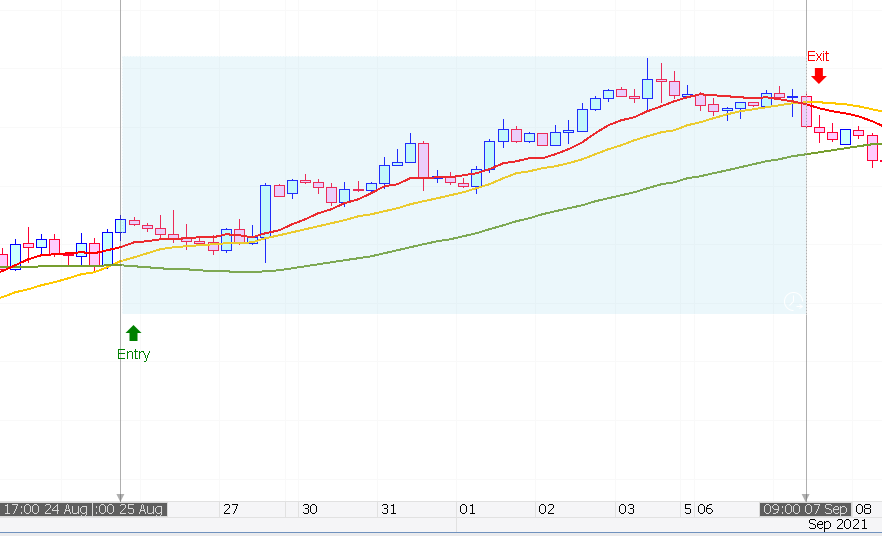

## Strategy Back-testing

Strategy back-testing is in essence test or run the strategy on historic data, "hoping" that past behavior will repeat inf future, which is not necessarily the case. It will depend on the data and the features used in the strategy an back-testing techniques used, but this discussion is out of the scope of this research.

### Imports

In [1]:
import pandas as pd
import numpy as np
import talib as ta

import sys

try:
    import mplfinance as mpf
except ImportError:
    %pip install mplfinance
    import mplfinance as mpf
    

try:
    import yfinance as yf
except ImportError:
    %pip install yfinance
    import yfinance as yf
    

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

### Global Variables

In [ ]:
SMA_fast = 10
SMA_med = 25
SMA_slow = 50

COL_f = f'SMA_{SMA_fast}'
COL_m = f'SMA_{SMA_med}'
COL_s = f'SMA_{SMA_slow}'

PLOT_FROM = 2000
PLOT_TO = 2200

SYMBOL='EURUSD=X'

DIGITS = 4  # digits where the pip change is counted
if 'JPY' in SYMBOL:
    DIGITS=2
    
PIP_FACTOR = 10**DIGITS  # factor to convert from points change to pip change

TRADE_COST = 0.5  # estimated spread + commission per trade


### Load Data

In [ ]:
df = pd.read_csv('EURUSD_Hourly_Bid_2015.01.01_2021.11.24.csv')
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)']) 
df.set_index('Time (UTC)', inplace=True)
df.head()

In [ ]:
# Downlaod data from yahoo finance using yfinance library
# Uncomment of you want to try different symbols

# df = yf.download(SYMBOL, 
#                       start='2020-01-01', 
#                       end='2021-12-31', 
#                       interval='1h',
#                       progress=False)
# df.head()

In [ ]:
print('Records ', df.shape[0])
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5),
         title=SYMBOL)

### Feature Calculation

Calculate $SMA_10$, $SMA_25$ and $SMA_50$ using pandas rolling windows

In [ ]:
df[COL_f] = df['Close'].rolling(SMA_fast).mean()
df[COL_m] = df['Close'].rolling(SMA_med).mean()
df[COL_s] = df['Close'].rolling(SMA_slow).mean()
df.dropna(inplace=True)

In [ ]:
ap0 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
       mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green')]

In [ ]:
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap0, title=f'{SYMBOL} / {COL_f} - {COL_m} - {COL_s}')

### Strategy Back-Testing

#### Entry and Exit Logic

**How to mark entry and exit signals?**

You need to be careful marking entry and exit events. Since a signal is marked once the period or bar is closed, you MUST mark the entry event right at the opening of next bar, that will be the entry bar. 


<b>Cross over condition signal</b>

Mathematically the signal is calculated as follows:

The signal corresponds when the last closes bar cross the fast SMA, along with fast SMA being above med SMA and med SMA being above the slow SMA.


$signal_i = (open_{i} < SMA_{fast, i} < close_{i})  \land (SMA_{slow, i} < SMA_{med, i} < SMA_{fast, i})$

Where:

* $Close_{i}$: Last closed bar close price.
* $Open_{i}$: Last closed bar open price.
* $SMA_{fast, i}, SMA_{med, i}, SMA_{slow, i}$: SMA fast, med and slow respectively, calculated at the last bar close.


<b>Entry condition</b>

The entry condition is risen right at the opening of current bar, if signal was risen for the last closed bar.


$entry_i=\begin{cases}
    1 \text{ if }signal_{i-1} = True\\
    \emptyset \text{ otherwise}
\end{cases}
$

Where:

* $entry_i$: Entry condition for current bar.
* $signal_{i-1}:$ Signal at last closed bar.


<b>Exit</b>

The exit signal is given when the close price crosses below the med SMA, therefore, following the entry signal/entry condition logic, the exit signal is risen right at the opening of current bar.

<b>Exit Signal</b>

$x\_signal_i = close_{i} < SMA_{med, i} < open_i$

<b>Exit Signal</b>

$exit_i = \begin{cases}
    -1 \text{ if }x\_signal_{i-1} = True \\
    \emptyset \text{ otherwise}
\end{cases}
$

In the example below:


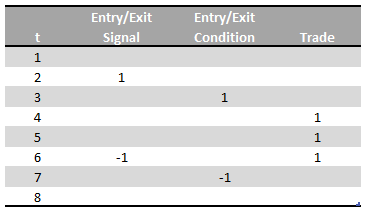	

- $t=2$: entry signal risen at the close of 2nd bar.
- $t=3$: entry condition is met, so a long trade is open right at the opening of the 3rd bar.
- $t=6$: exit signal is risen at the close of 6th bar.
- $t=7$: exit condition is met, so the trade is closed right at the opening of the 7th bar.


#### Mark Entry and Exit Signal

In [ ]:
df['trade'] = np.nan
df['signal'] = np.nan
df['entry'] = np.nan
df['exit'] = np.nan

# mark entry signal
mask_signal =    (df['Close'] > df[COL_f]) & (df['Open'] < df[COL_f]) & \
                 (df[COL_f] > df[COL_m]) &  (df[COL_m] > df[COL_s]) # SMA positioning
df.loc[mask_signal, 'signal'] = 1
df.loc[(df['signal']==1), 'plot_signal'] = df[COL_s] - 0.0010

# mark exit signal
mask_x_signal = (df['Close'] < df[COL_m]) & (df['Open'] >  df[COL_m])
df.loc[mask_x_signal, 'signal'] = -1 
df.loc[(df['signal']==-1), 'x_plot_signal'] = df['High'] + 0.0010



"""
mask_entry = (mask_cxo.shift(1) == True) & (mask_cxo.shift(2) == False) & (df['Close'] > df[COL_f])

df.loc[mask_entry, 'trade'] = range(1, len(df[mask_entry])+1)

df.loc[(df['trade']>=1), 'plot_entry'] = df[COL_s] - 0.0010

mask_exit = ( df['Close'].shift(1) < df[COL_m].shift(1)) 
df.loc[mask_exit, 'trade'] = -1
df.loc[(df['trade']==-1), 'plot_exit'] = df[COL_s] - 0.0010
"""

In [ ]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_signal'],type='scatter', marker=6, color="r"),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['x_plot_signal'],type='scatter', marker=7, color="b"),

      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Trade Entry-Exit Events')

#### Mark Entry/Exit condition

In [ ]:
# mark entry/exit condition

df['EN_EX_cond'] = df['signal'].shift(1)
df[['signal', 'EN_EX_cond']][2188:2200]

#### Mark Trades

In [ ]:
# mark trades periods
df['trade'] = df['EN_EX_cond']
df['trade'].ffill(inplace=True)
df['trade'] =  df['trade'].replace(-1, np.nan)
mask_trade = df['trade'].isna()
df.loc[~mask_trade, 'plot_trade'] = df.loc[~mask_trade][COL_s] - 0.0005

# generate trades id
mask_trade_start = (df['trade'] == 1 ) & (df['trade'].shift(1).isna())  # marks trade start
# df['trade_id'] = 0
df.loc[mask_trade_start, 'trade_id'] = range(1, len(df[mask_trade_start])+1)
df['trade_id'].ffill(inplace=True)
df.loc[df['trade'].isna(), 'trade_id'] = np.nan


In [ ]:
df[['trade', 'trade_id']][2190:2200]

In [ ]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_trade'],type='scatter', marker=6, color="b")
      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Trade Entry-Exit Events')

#### Calculate Profit [pips]

In [ ]:
def profit_report_col(df, column='net_profit'):

        # NON FILTERED
        _mask_tot = df[column] !=0
        _tot_trades = len(df[_mask_tot])

        _mask_win_trades = df[column] > 0
        _tot_win_trades = len(df[_mask_win_trades])
        _tot_win_pft = df[_mask_win_trades][column].sum().round(2)

        _mask_los_trades = df[column] < 0
        _tot_los_trades = len(df[_mask_los_trades])
        _tot_loss_pft = df[_mask_los_trades][column].sum().round(2)

        _total_pft = df[column].sum().round(2)
        _mean_pft = df[column].mean().round(2)
        _std_pft = df[column].std().round(2)
        
        _median_pft = df[column].median().round(2)
        _mode_pft = df[column].mode().round(2)
        
        _skew_pft = df[column].skew().round(2)

        _report = dict()
        _report['column'] = column
        _report['tot_trades'] = _tot_trades
        _report['tot_win_trades'] = _tot_win_trades
        _report['tot_losing_trades'] = _tot_los_trades
        _report['net_profit'] = _total_pft
        _report['win_profit'] = _tot_win_pft
        _report['losing_profit'] = _tot_loss_pft
        _report['avg_profit'] = _mean_pft 
        _report['std_profit'] = _std_pft 
        _report['median_profit'] = _median_pft
        _report['mode_profit'] = _mode_pft[0]
        _report['skew_profit'] = _skew_pft

        return _report

In [ ]:
df['date'] = df.index
mask_trade = df['trade_id']>0
df.loc[mask_trade, 'gross_profit'] = (df.loc[mask_trade, 'Close'] - df.loc[mask_trade, 'Open'] )*PIP_FACTOR
df_trades_pft = df[['trade_id', 'gross_profit']].groupby(by='trade_id').sum()
df_trades_date = df[['trade_id', 'date']].groupby(by='trade_id').min()

In [ ]:
df[['trade', 'trade_id', 'gross_profit']][2190:2200]

In [ ]:
df_trades_pft

In [ ]:
df_trades = pd.merge(df_trades_pft, df_trades_date, how='inner', left_index=True, right_index=True)
df_trades.set_index('date', inplace=True)

In [ ]:
df_trades['net_profit'] = df_trades['gross_profit'] - TRADE_COST
df_trades[['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))
plt.show()

In [ ]:
df_trades.head(5)

In [ ]:
report = profit_report_col(df_trades)
for k  in report:
    print(k, '\t  :', report[k])

In [ ]:
mean_x = report['avg_profit']
median_x = report['median_profit']

fig, axis=plt.subplots(1,1, figsize=(10,4))
df_trades['net_profit'].hist(grid=False, bins=50)
plt.plot([mean_x, mean_x], [0, 70], color='g', linestyle='--', label='mean')
plt.plot([median_x, median_x], [0, 70], color='orange', linestyle='--', label='median')
plt.legend()
plt.title('Profit distribution', size=16)
plt.show()

**Observations**

Even though the strategy is profitable for the time range back-tested, it is not consistent.

Mainly relies on outliers, which pull the mean (expected profit) to the positive side, but the median (less sensitive to outliers) is negative, showing that the bulk of the trades are in the negative side. A good strategy would have both statistics in the positive side.

All this is confirmed by skewness which is positive indicating a right tailed distribution, which is not good considering median below zero.

What if outliers are removed?. The hypothesis is that this strategy relies only on outliers, and removing them would turn this strategy into a losing one in average, meaning that the average profit should shift to the negative side.

## Removing Outliers

There are many ways to remove outliers, for example using standard deviation, or trimming the extremes. The later will used here. So I will remove both, the bottom and top 10% of the profits range.

For that purpose I will use pandas quantile function, which returns the value at which a specific quantile is located.

In this case the following range will be selected.

$Q_{10} <= profit_{net} <= Q_{90}$

In [ ]:
mask_10_off = (df_trades['net_profit'] >= df_trades['net_profit'].quantile(.1)) & (df_trades['net_profit'] <= df_trades['net_profit'].quantile(.95))

In [ ]:
mean_x = df_trades[mask_10_off]['net_profit'].mean()
median_x = df_trades[mask_10_off]['net_profit'].median()

fig, axis=plt.subplots(1,1, figsize=(10,4))
df_trades.loc[mask_10_off, 'net_profit'].hist(grid=False, bins=50)
plt.plot([mean_x, mean_x], [0, 70], color='g', linestyle='--', label='mean')
plt.plot([median_x, median_x], [0, 70], color='orange', linestyle='--', label='median')
plt.legend()
plt.title('Profit distribution (10% trimmed profits)', size=16)
plt.show()

print("Average Profit ", mean_x)
print("Profit median", median_x)

As expeccted, the mean has moved to the negative side, becuase of the removing of outliers, meaning that this strategy is no longer consistently profitable.

In [ ]:

df_trades[mask_10_off][['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))
plt.show()

Clearly, from cumulative profit chart, is possible to verify that removed outliers has impacted the strategy perofrmance, but the question that remains is: is this impact staisticaly significant?

## Next: A/B testing on average profit change